# Import libraries

In [1]:
import xarray as xr 
import rioxarray as rio 
import pandas as pd
from datetime import datetime as dt
import datetime
import rasterio
from rasterio.plot import show
import numpy as np
import os, sys
import glob
import json
import netCDF4
import h5netcdf
import matplotlib.pyplot as plt
import geopandas as gpd
from pathlib import Path

# Import functions

In [2]:
from requests import get
from pandas import json_normalize

#https://open-meteo.com/en/docs/elevation-api#api-documentation

def get_elevation(lat = None, long = None):
    '''
        script for returning elevation in m from lat, long
    '''
    if lat is None or long is None: return None
    
    query = (f'https://api.open-meteo.com/v1/elevation?latitude={lat}&longitude={long}')
    
    # Request with a timeout for slow responses
    r = get(query, timeout = 20)

    # Only get the json response in case of 200 or 201
    if r.status_code == 200 or r.status_code == 201:
        elevation = r.json()['elevation'][0]
    else: 
        elevation = None
    return elevation

In [3]:
from eto import ETo, datasets
import pandas as pd

et1 = ETo()

# Global settings

### Define AOI

In [4]:
aoi =  gpd.read_file('/home/c4ubuntu/c4gdata/SADC_Data/GIS/Luangwa.shp')

aoi.to_crs(4326, inplace=True)

# AgERA

In [5]:
ag_data = '/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/'

**Explore data**

In [6]:
os.listdir('/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/3_combined/')

['.ipynb_checkpoints',
 'AgERA5_SADC_10m_wind_speed_24_hour_mean.nc',
 'AgERA5_SADC_2m_temperature_24_hour_maximum.nc',
 'AgERA5_SADC_2m_temperature_24_hour_minimum.nc',
 'AgERA5_SADC_precipitation_flux_daily.nc',
 'AgERA5_SADC_solar_radiation_flux_daily.nc',
 'AgERA5_SADC_vapour_pressure_24_hour_mean.nc',
 'AgERA5_Swaziland_10m_wind_speed_24_hour_mean.nc',
 'AgERA5_Swaziland_2m_temperature_24_hour_maximum.nc',
 'AgERA5_Swaziland_2m_temperature_24_hour_minimum.nc',
 'AgERA5_Swaziland_precipitation_flux_daily.nc',
 'AgERA5_Swaziland_solar_radiation_flux_daily.nc',
 'AgERA5_Swaziland_vapour_pressure_24_hour_mean.nc']

In [8]:
ds = xr.open_dataset('/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/3_combined/AgERA5_SADC_precipitation_flux_daily.nc')

dates = ds.time.dt.date.astype(str).values
# year value for each time step
years=ds.time.dt.year.data
#unique years
uniqueyears=np.unique(years)
# number of years
nyears=len(uniqueyears)

<Axes: title={'center': 'time = 1979-01-01'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

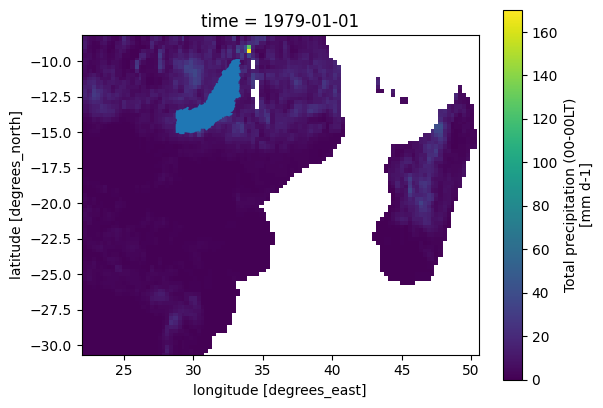

In [9]:
fig, ax = plt.subplots()

ds.Precipitation_Flux[0,:,:].plot(ax=ax)
aoi.plot(ax=ax)

In [10]:
variables = []
for file in glob.glob(os.path.join(ag_data,'3_combined','AgERA5_SADC*')):
    x = os.path.basename(file).split('_SADC_')[-1].replace('.nc', '')
    variables.append(x)
variables = np.unique(variables)

In [11]:
variables

array(['10m_wind_speed_24_hour_mean', '2m_temperature_24_hour_maximum',
       '2m_temperature_24_hour_minimum', 'precipitation_flux_daily',
       'solar_radiation_flux_daily', 'vapour_pressure_24_hour_mean'],
      dtype='<U30')

In [12]:
signifdigits=3
data_type = 'AgERA5'
country = 'Zambia'
outdir= f'/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/{data_type}/{country}/'

In [13]:
# Get the file names
tmin_file = glob.glob(os.path.join(ag_data,'3_combined',f'AgERA5_SADC_{variables[2]}*'))[0]
tmax_file = glob.glob(os.path.join(ag_data,'3_combined',f'AgERA5_SADC_{variables[1]}*'))[0]
pr_file = glob.glob(os.path.join(ag_data,'3_combined',f'AgERA5_SADC_{variables[3]}*'))[0]
solar_file = glob.glob(os.path.join(ag_data,'3_combined',f'AgERA5_SADC_{variables[-2]}*'))[0]
sfcWind_file = glob.glob(os.path.join(ag_data,'3_combined',f'AgERA5_SADC_{variables[0]}*'))[0]
vap_file = glob.glob(os.path.join(ag_data,'3_combined',f'AgERA5_SADC_{variables[-1]}*'))[0]

In [14]:
#Read the datasets
ds = xr.open_dataset(tmin_file)
ds1 = xr.open_dataset(tmax_file)
ds2 = xr.open_dataset(sfcWind_file)
ds3 = xr.open_dataset(pr_file)
ds4 = xr.open_dataset(solar_file)
ds5 = xr.open_dataset(vap_file)

In [15]:
dates = ds.time.dt.date.astype(str).values
signifdigits=3

In [16]:
# Write spatial info and clip to AOI
ds = ds.rio.write_crs(4326)
ds = ds.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
ds = ds.rio.clip(aoi.geometry, 'epsg:4326', drop=True)

In [91]:
# Write spatial info and clip to AOI
ds1 = ds1.rio.write_crs(4326)
ds1 = ds1.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
ds1 = ds1.rio.clip(aoi.geometry, 'epsg:4326', drop=True)
    
# Write spatial info and clip to AOI
ds2 = ds2.rio.write_crs(4326)
ds2 = ds2.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
ds2 = ds2.rio.clip(aoi.geometry, 'epsg:4326', drop=True)

# Write spatial info and clip to AOI
ds3 = ds3.rio.write_crs(4326)
ds3 = ds3.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
ds3 = ds3.rio.clip(aoi.geometry, 'epsg:4326', drop=True)

# Write spatial info and clip to AOI
ds4 = ds4.rio.write_crs(4326)
ds4 = ds4.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
ds4 = ds4.rio.clip(aoi.geometry, 'epsg:4326', drop=True)

# Write spatial info and clip to AOI
ds5 = ds5.rio.write_crs(4326)
ds5 = ds5.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
ds5 = ds5.rio.clip(aoi.geometry, 'epsg:4326', drop=True)

In [92]:
#extracting data for the current variable
tasmin=ds["Temperature_Air_2m_Min_24h"]-273.15
tasmax=ds1["Temperature_Air_2m_Max_24h"]-273.15
sfcWind=ds2['Wind_Speed_10m_Mean']
pr=ds3["Precipitation_Flux"]
solar = ds4['Solar_Radiation_Flux']
vap = ds5['Vapour_Pressure_Mean']

In [93]:
header = 'T_min,T_max,Precipitation,U_z,Date\n'

#iterating through latitudes and longitudes
for lat in ds.lat.data:
    for lon in ds.lon.data:
        latstring=np.round(lat.data,2)
        lonstring=np.round(lon.data,2)
        outfilename="{}_{}_{}_{}.csv".format(data_type,country,latstring,lonstring)
        outfile="{}/{}".format(outdir,outfilename)
        #data for given lat and lon
        site_tasmin=np.round(tasmin.sel(lat=lat, lon=lon).data,signifdigits)
        site_tasmax=np.round(tasmax.sel(lat=lat, lon=lon).data,signifdigits)
        site_pr=np.round(pr.sel(lat=lat, lon=lon).data,signifdigits)
        site_sfcWind=np.round(sfcWind.sel(lat=lat, lon=lon).data,signifdigits)
        if np.count_nonzero(np.isnan(site_tasmax)) == 0:  
        #opening file for writing
            with open(outfile, "w") as outf:
                outf.write(header)
            #iterating through time steps
                for i in range(site_tasmin.shape[0]):
                    line=f"%.2f,%.2f,%.2f,%.2f,{dates[i]}\n"%(site_tasmin[i],site_tasmax[i],
                                                                        site_pr[i],site_sfcWind[i])
                    outf.write(line)
            print(outfile)
            # Calculate ET0
            tsdata = pd.read_csv(outfile, parse_dates=True, infer_datetime_format=True, index_col='Date')
            tsdata = tsdata.dropna()

            try:
                z_msl = get_elevation(lat=latstring, long=lonstring)
            except:
                print('Something wrong with elevation')
            freq = 'D'
            tsdata = tsdata[['T_min', 'T_max', 'Precipitation', 'U_z']]
            et1 = ETo()

            et1.param_est(tsdata, freq, z_msl, latstring, lonstring)

            eto1 = et1.eto_fao()
            sitefile_eto = pd.concat([tsdata, eto1], axis=1).reset_index()
            sitefile_eto.rename(columns={'T_min':'MinTemp', 'T_max':'MaxTemp', 
                                         'ETo_FAO_mm':'ReferenceET'}, inplace=True)
            sitefile_eto[["MinTemp","MaxTemp","Precipitation","ReferenceET","Date"]].to_csv(outfile)

/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-9.9_32.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-9.9_33.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-9.9_33.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-9.9_33.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-9.9_33.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-10.0_32.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-10.0_32.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-10.0_33.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-10.0_33.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-10.0_33.2.csv
/home

/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-10.8_33.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-10.8_33.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-10.8_33.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-10.8_33.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-10.9_32.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-10.9_32.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-10.9_32.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-10.9_32.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-10.9_32.5.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-10.9_32.6.csv


/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.4_32.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.4_32.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.4_33.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.4_33.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.4_33.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.5_31.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.5_31.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.5_32.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.5_32.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.5_32.2.csv


/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.9_27.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.9_31.5.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.9_31.6.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.9_31.7.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.9_31.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.9_31.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.9_32.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.9_32.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.9_32.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-11.9_32.3.csv


/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.1_32.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.1_32.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.1_33.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.1_33.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.1_33.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.2_26.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.2_26.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.2_26.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.2_26.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.2_26.4.csv


/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.3_33.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.4_26.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.4_26.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.4_26.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.4_26.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.4_26.5.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.4_26.6.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.4_26.7.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.4_26.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.4_26.9.csv


/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.5_32.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.5_32.5.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.5_32.6.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.5_32.7.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.5_32.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.5_32.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.5_33.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.5_33.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.5_33.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.5_33.3.csv


/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.7_31.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.7_31.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.7_31.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.7_31.5.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.7_31.6.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.7_31.7.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.7_31.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.7_31.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.7_32.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.7_32.1.csv


/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.9_27.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.9_28.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.9_28.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.9_28.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.9_28.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.9_28.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.9_28.5.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.9_28.6.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.9_28.7.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-12.9_30.9.csv


Something wrong with elevation
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.1_25.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.1_26.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.1_26.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.1_26.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.1_26.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.1_26.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.1_26.5.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.1_26.6.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.1_26.7.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia

/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.2_28.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.2_28.5.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.2_28.6.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.2_28.7.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.2_28.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.2_28.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.2_30.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.2_30.5.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.2_30.6.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.2_30.7.csv


/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.3_31.6.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.3_31.7.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.3_31.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.3_31.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.3_32.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.3_32.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.3_32.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.3_32.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.3_32.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.3_32.5.csv


/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.5_25.7.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.5_25.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.5_25.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.5_26.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.5_26.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.5_26.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.5_26.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.5_26.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.5_26.5.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.5_26.6.csv


/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.6_26.6.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.6_26.7.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.6_26.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.6_26.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.6_27.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.6_27.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.6_27.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.6_27.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.6_27.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.6_27.5.csv


/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.7_27.7.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.7_27.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.7_27.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.7_28.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.7_28.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.7_28.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.7_28.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.7_28.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.7_28.5.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.7_28.6.csv


/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.8_28.6.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.8_28.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.8_28.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.8_29.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.8_29.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.8_29.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.8_29.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.8_29.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.8_29.5.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.8_29.6.csv


/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.9_29.7.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.9_29.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.9_29.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.9_30.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.9_30.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.9_30.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.9_30.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.9_30.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.9_30.5.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-13.9_30.6.csv


/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.0_31.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.0_31.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.0_31.5.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.0_31.6.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.0_31.7.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.0_31.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.0_31.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.0_32.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.1_25.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.1_25.5.csv


/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.2_26.6.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.2_26.7.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.2_26.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.2_26.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.2_27.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.2_27.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.2_27.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.2_27.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.2_27.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.2_27.5.csv


/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.3_29.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.3_29.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.3_29.5.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.3_29.6.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.3_29.7.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.3_29.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.3_29.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.3_30.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.3_30.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.3_30.2.csv


Something wrong with elevation
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.5_26.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.5_26.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.5_26.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.5_26.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.5_26.5.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.5_26.6.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.5_26.7.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.5_26.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.5_26.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia

/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.6_29.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.6_30.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.6_30.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.6_30.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.6_30.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.6_30.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.6_30.5.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.6_30.6.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.6_30.7.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.6_30.8.csv


/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.8_29.6.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.8_29.7.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.8_29.8.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.8_29.9.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.8_30.0.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.8_30.1.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.8_30.2.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.8_30.3.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.8_30.4.csv
/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/AgERA5/Zambia//AgERA5_Zambia_-14.8_30.5.csv


In [17]:
latlons_luangwa = []
for lat in ds.lat.data:
    for lon in ds.lon.data:
        latstring=np.round(lat.data,2)
        lonstring=np.round(lon.data,2)
        latlons_luangwa.append({'lat':latstring, 'lon':lonstring})

In [22]:
DataDir = '/home/c4ubuntu/c4gdata/SADC_Agri/Data/'

In [23]:
with open(os.path.join(DataDir,'GIS','Gridpoints',f'{country}_points_soils_dict.json')) as json_file:
    countries_points_dict = json.load(json_file)

In [41]:
latlons_luangwa

[{'lat': -9.9, 'lon': 28.8},
 {'lat': -9.9, 'lon': 28.9},
 {'lat': -9.9, 'lon': 29.0},
 {'lat': -9.9, 'lon': 29.1},
 {'lat': -9.9, 'lon': 29.2},
 {'lat': -9.9, 'lon': 29.3},
 {'lat': -9.9, 'lon': 29.4},
 {'lat': -9.9, 'lon': 29.5},
 {'lat': -9.9, 'lon': 29.6},
 {'lat': -9.9, 'lon': 29.7},
 {'lat': -9.9, 'lon': 29.8},
 {'lat': -9.9, 'lon': 29.9},
 {'lat': -9.9, 'lon': 30.0},
 {'lat': -9.9, 'lon': 30.1},
 {'lat': -9.9, 'lon': 30.2},
 {'lat': -9.9, 'lon': 30.3},
 {'lat': -9.9, 'lon': 30.4},
 {'lat': -9.9, 'lon': 30.5},
 {'lat': -9.9, 'lon': 30.6},
 {'lat': -9.9, 'lon': 30.7},
 {'lat': -9.9, 'lon': 30.8},
 {'lat': -9.9, 'lon': 30.9},
 {'lat': -9.9, 'lon': 31.0},
 {'lat': -9.9, 'lon': 31.1},
 {'lat': -9.9, 'lon': 31.2},
 {'lat': -9.9, 'lon': 31.3},
 {'lat': -9.9, 'lon': 31.4},
 {'lat': -9.9, 'lon': 31.5},
 {'lat': -9.9, 'lon': 31.6},
 {'lat': -9.9, 'lon': 31.7},
 {'lat': -9.9, 'lon': 31.8},
 {'lat': -9.9, 'lon': 31.9},
 {'lat': -9.9, 'lon': 32.0},
 {'lat': -9.9, 'lon': 32.1},
 {'lat': -9.9,

In [46]:
keep = []
for row in countries_points_dict:
    lat = row.get('lat')
    lon = row.get('lon')
    for i in latlons_luangwa:
        if [lat, lon] == [i.get('lat'), i.get('lon')]:
            keep.append(row)

In [48]:
len(keep)

1098

In [50]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32,
                              np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [51]:
json_str = json.dumps(keep, cls=NumpyEncoder)

# open file for writing, "w" 
f = open(f"{DataDir}GIS/Gridpoints/luangwa_points_soils_dict.json","w")

# write json object to file
f.write(json_str)

# close file
f.close()

# CMIP6

#### Get list of models

In [7]:
os.listdir(os.path.join('/home/c4ubuntu/c4gdata/SADC_Data/luangwa/'))

['hurs_day_ACCESS-CM2_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_CMCC-ESM2_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_INM-CM4-8_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_INM-CM5-0_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_INM-CM5-0_historical-ssp585_1979-2100_luangwa_bc.nc',
 'hurs_day_KACE-1-0-G_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_KIOST-ESM_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_MIROC-ES2L_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_MIROC6_historical-ssp585_1979-2100_luangwa_bc.nc',
 'hurs_day_MPI-ESM1-2-LR_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_MPI-ESM1-2-LR_historical-ssp585_1979-2100_luangwa_bc.nc',
 'hurs_day_MRI-ESM2-0_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_MRI-ESM2-0_historical-ssp585_1979-2100_luangwa_bc.nc',
 'hurs_day_NorESM2-MM_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_UKESM1-0-LL_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_U

In [33]:
models = []
for file in os.listdir(os.path.join('/home/c4ubuntu/c4gdata/SADC_Data/luangwa/')):
    x = file.split('_')[2]
    models.append(x)
models = np.unique(models)

In [34]:
models

array(['ACCESS-CM2', 'CMCC-ESM2', 'INM-CM4-8', 'INM-CM5-0', 'KACE-1-0-G',
       'KIOST-ESM', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-LR', 'MRI-ESM2-0',
       'NorESM2-MM', 'UKESM1-0-LL'], dtype='<U13')

#### Get list of variables

In [10]:
variables = []
for file in os.listdir('/home/c4ubuntu/c4gdata/SADC_Data/luangwa/'):
    x = file.split('_')[0]
    variables.append(x)
variables = np.unique(variables)

In [11]:
variables

array(['hurs', 'pr', 'sfcWind', 'tasmax', 'tasmin'], dtype='<U7')

### Explore data

In [12]:
os.listdir('/home/c4ubuntu/c4gdata/SADC_Data/luangwa/')

['hurs_day_ACCESS-CM2_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_CMCC-ESM2_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_INM-CM4-8_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_INM-CM5-0_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_INM-CM5-0_historical-ssp585_1979-2100_luangwa_bc.nc',
 'hurs_day_KACE-1-0-G_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_KIOST-ESM_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_MIROC-ES2L_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_MIROC6_historical-ssp585_1979-2100_luangwa_bc.nc',
 'hurs_day_MPI-ESM1-2-LR_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_MPI-ESM1-2-LR_historical-ssp585_1979-2100_luangwa_bc.nc',
 'hurs_day_MRI-ESM2-0_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_MRI-ESM2-0_historical-ssp585_1979-2100_luangwa_bc.nc',
 'hurs_day_NorESM2-MM_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_UKESM1-0-LL_historical-ssp245_1979-2100_luangwa_bc.nc',
 'hurs_day_U

In [13]:
ds = xr.open_dataset('/home/c4ubuntu/c4gdata/SADC_Data/luangwa/pr_day_CMCC-ESM2_historical-ssp245_1979-2100_luangwa_bc.nc')

In [14]:
dates = ds.time.dt.date.astype(str).values
# year value for each time step
years=ds.time.dt.year.data
#unique years
uniqueyears=np.unique(years)
# number of years
nyears=len(uniqueyears)

signifdigits=3

### Calculate ETo

In [15]:
from eto import ETo, datasets
import pandas as pd

et1 = ETo()

### Export sitefiles

In [28]:
variables

array(['hurs', 'pr', 'sfcWind', 'tasmax', 'tasmin'], dtype='<U7')

In [35]:
models

array(['ACCESS-CM2', 'CMCC-ESM2', 'INM-CM4-8', 'INM-CM5-0', 'KACE-1-0-G',
       'KIOST-ESM', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-LR', 'MRI-ESM2-0',
       'NorESM2-MM', 'UKESM1-0-LL'], dtype='<U13')

In [36]:
country = 'Zambia'
experiment = 'ssp585'
data_type = 'CMIP6'
outdir= f'/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/{data_type}/{country}/'
country_small = 'luangwa'

model_list = []

for model in models:
    # Get the file names
    try:
        tmin_file = glob.glob(f'/home/c4ubuntu/c4gdata/SADC_Data/{country_small}/tasmin_day_{model}*{experiment}*')[0]
        model_list.append(model)
    except:
        print(f'No data for {model}')
    if os.path.exists(outdir+model):
        modeldir = outdir+model
    else:
        os.mkdir(outdir+model)
        modeldir = outdir+model

No data for ACCESS-CM2
No data for CMCC-ESM2
No data for INM-CM4-8
No data for KACE-1-0-G
No data for KIOST-ESM
No data for MIROC-ES2L
No data for NorESM2-MM


In [37]:
model_list

['INM-CM5-0', 'MIROC6', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'UKESM1-0-LL']

In [28]:
country = 'Zambia'

experiment = 'ssp585'

data_type = 'CMIP6'

outdir= f'/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/{data_type}/{country}/'

country_small = 'luangwa'

model_list = ['INM-CM5-0', 'MIROC-ES2L']

for model in model_list:
    print(model)
    if os.path.exists(outdir+model):
        modeldir = outdir+model
    else:
        os.mkdir(outdir+model)
        modeldir = outdir+model
    # Get the file names
    tmin_file = glob.glob(f'/home/c4ubuntu/c4gdata/SADC_Data/{country_small}/tasmin_day_{model}*{experiment}*')[0]
    tmax_file = glob.glob(f'/home/c4ubuntu/c4gdata/SADC_Data/{country_small}/tasmax_day_{model}*{experiment}*')[0]
    pr_file = glob.glob(f'/home/c4ubuntu/c4gdata/SADC_Data/{country_small}/pr_day_{model}*{experiment}*')[0]
    hurs_file = glob.glob(f'/home/c4ubuntu/c4gdata/SADC_Data/{country_small}/hurs_day_{model}*{experiment}*')[0]
    sfcWind_file = glob.glob(f'/home/c4ubuntu/c4gdata/SADC_Data/{country_small}/sfcWind_day_{model}*{experiment}*')[0]
    
    #Read the datasets
    ds = xr.open_dataset(tmin_file)
    ds1 = xr.open_dataset(tmax_file)
    ds2 = xr.open_dataset(sfcWind_file)
    ds3 = xr.open_dataset(pr_file)
    ds4 = xr.open_dataset(hurs_file)
    
    dates = ds.time.dt.date.astype(str).values
    signifdigits=3
    
    #extracting data for the current variable
    tasmin=ds["tasmin"]-273.15
    tasmax=ds1["tasmax"]-273.15
    sfcWind=ds2['__xarray_dataarray_variable__']
    pr=ds3["pr"]
    hurs=ds4["__xarray_dataarray_variable__"]
    
    
    # Write spatial info and clip to AOI
    ds = ds.rio.write_crs(4326)
    ds = ds.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    ds = ds.rio.clip(aoi.geometry, 'epsg:4326', drop=True)
    
    # Write spatial info and clip to AOI
    ds1 = ds1.rio.write_crs(4326)
    ds1 = ds1.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    ds1 = ds1.rio.clip(aoi.geometry, 'epsg:4326', drop=True)
        
    # Write spatial info and clip to AOI
    ds2 = ds2.rio.write_crs(4326)
    ds2 = ds2.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    ds2 = ds2.rio.clip(aoi.geometry, 'epsg:4326', drop=True)
    
    # Write spatial info and clip to AOI
    ds3 = ds3.rio.write_crs(4326)
    ds3 = ds3.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    ds3 = ds3.rio.clip(aoi.geometry, 'epsg:4326', drop=True)
    
    # Write spatial info and clip to AOI
    ds4 = ds4.rio.write_crs(4326)
    ds4 = ds4.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    ds4 = ds4.rio.clip(aoi.geometry, 'epsg:4326', drop=True)
    
    header = 'T_min,T_max,Precipitation,U_z,RH_mean,Date\n'

    #extracting data for the current variable
    tasmin=ds["tasmin"]-273.15
    tasmax=ds1["tasmax"]-273.15
    sfcWind=ds2['__xarray_dataarray_variable__']
    pr=ds3["pr"]
    hurs=ds4["__xarray_dataarray_variable__"]
    n = 0
    #iterating through latitudes and longitudes
    for lat in ds.lat.data:
        for lon in ds.lon.data:
            latstring=np.round(lat.data,2)
            lonstring=np.round(lon.data,2)
            outfilename="{}_{}_{}_{}_{}.csv".format(experiment,model,country,latstring,lonstring)
            outfile="{}/{}".format(modeldir,outfilename)
            if os.path.exists(outfile):
                print('File done: ', outfile)
            else:
                #data for given lat and lon
                site_tasmin=np.round(tasmin.sel(lat=lat, lon=lon).data,signifdigits)
                site_tasmax=np.round(tasmax.sel(lat=lat, lon=lon).data,signifdigits)
                site_pr=np.round(pr.sel(lat=lat, lon=lon).data,signifdigits)
                site_sfcWind=np.round(sfcWind.sel(lat=lat, lon=lon).data,signifdigits)
                site_hurs=np.round(hurs.sel(lat=lat, lon=lon).data,signifdigits)

                if np.count_nonzero(np.isnan([site_tasmin, site_tasmax, site_pr])) == 0:    
                #opening file for writing
                    with open(outfile, "w") as outf:
                        outf.write(header)
                    #iterating through time steps
                        for i in range(site_tasmin.shape[0]):
                            line="{},{},{},{},{},{}\n".format(site_tasmin[i],site_tasmax[i],site_pr[i],site_sfcWind[i],
                                                              site_hurs[i],dates[i])
                            outf.write(line)
                    #print(outfile)
                    # Calculate ET0
                    tsdata = pd.read_csv(outfile, parse_dates=True, infer_datetime_format=True, index_col='Date')
                    try:
                        z_msl = get_elevation(lat=latstring, long=lonstring)
                    except:
                        print('Something wrong with elevation')
                    freq = 'D'
                    et1 = ETo()

                    et1.param_est(tsdata, freq, z_msl, latstring, lonstring)

                    eto1 = et1.eto_fao()

                    sitefile_eto = pd.concat([tsdata, eto1], axis=1).reset_index()
                    sitefile_eto.rename(columns={'T_min':'MinTemp', 'T_max':'MaxTemp', 
                                                 'ETo_FAO_mm':'ReferenceET'}, inplace=True)
                    sitefile_eto[["MinTemp","MaxTemp","Precipitation","ReferenceET","Date"]].to_csv(outfile)
                    n = n+1
                    print(n)

UKESM1-0-LL
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274


In [29]:
country = 'Zambia'

experiment = 'ssp585'

data_type = 'CMIP6'

outdir= f'/home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/{data_type}/{country}/'

country_small = 'luangwa'


for model in model_list[:-1]:
    print(model)
    if os.path.exists(outdir+model):
        modeldir = outdir+model
    else:
        os.mkdir(outdir+model)
        modeldir = outdir+model
    # Get the file names
    tmin_file = glob.glob(f'/home/c4ubuntu/c4gdata/SADC_Data/{country_small}/tasmin_day_{model}*{experiment}*')[0]
    tmax_file = glob.glob(f'/home/c4ubuntu/c4gdata/SADC_Data/{country_small}/tasmax_day_{model}*{experiment}*')[0]
    pr_file = glob.glob(f'/home/c4ubuntu/c4gdata/SADC_Data/{country_small}/pr_day_{model}*{experiment}*')[0]
    hurs_file = glob.glob(f'/home/c4ubuntu/c4gdata/SADC_Data/{country_small}/hurs_day_{model}*{experiment}*')[0]
    sfcWind_file = glob.glob(f'/home/c4ubuntu/c4gdata/SADC_Data/{country_small}/sfcWind_day_{model}*{experiment}*')[0]
    
    #Read the datasets
    ds = xr.open_dataset(tmin_file)
    ds1 = xr.open_dataset(tmax_file)
    ds2 = xr.open_dataset(sfcWind_file)
    ds3 = xr.open_dataset(pr_file)
    ds4 = xr.open_dataset(hurs_file)
    
    dates = ds.time.dt.date.astype(str).values
    signifdigits=3
    
    #extracting data for the current variable
    tasmin=ds["tasmin"]-273.15
    tasmax=ds1["tasmax"]-273.15
    sfcWind=ds2['__xarray_dataarray_variable__']
    pr=ds3["pr"]
    hurs=ds4["__xarray_dataarray_variable__"]
    
    
    # Write spatial info and clip to AOI
    ds = ds.rio.write_crs(4326)
    ds = ds.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    ds = ds.rio.clip(aoi.geometry, 'epsg:4326', drop=True)
    
    # Write spatial info and clip to AOI
    ds1 = ds1.rio.write_crs(4326)
    ds1 = ds1.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    ds1 = ds1.rio.clip(aoi.geometry, 'epsg:4326', drop=True)
        
    # Write spatial info and clip to AOI
    ds2 = ds2.rio.write_crs(4326)
    ds2 = ds2.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    ds2 = ds2.rio.clip(aoi.geometry, 'epsg:4326', drop=True)
    
    # Write spatial info and clip to AOI
    ds3 = ds3.rio.write_crs(4326)
    ds3 = ds3.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    ds3 = ds3.rio.clip(aoi.geometry, 'epsg:4326', drop=True)
    
    # Write spatial info and clip to AOI
    ds4 = ds4.rio.write_crs(4326)
    ds4 = ds4.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
    ds4 = ds4.rio.clip(aoi.geometry, 'epsg:4326', drop=True)
    
    header = 'T_min,T_max,Precipitation,U_z,RH_mean,Date\n'

    #extracting data for the current variable
    tasmin=ds["tasmin"]-273.15
    tasmax=ds1["tasmax"]-273.15
    sfcWind=ds2['__xarray_dataarray_variable__']
    pr=ds3["pr"]
    hurs=ds4["__xarray_dataarray_variable__"]
    n = 0
    #iterating through latitudes and longitudes
    for lat in ds.lat.data:
        for lon in ds.lon.data:
            latstring=np.round(lat.data,2)
            lonstring=np.round(lon.data,2)
            outfilename="{}_{}_{}_{}_{}.csv".format(experiment,model,country,latstring,lonstring)
            outfile="{}/{}".format(modeldir,outfilename)
            if os.path.exists(outfile):
                print('File done: ', outfile)
            else:
                #data for given lat and lon
                site_tasmin=np.round(tasmin.sel(lat=lat, lon=lon).data,signifdigits)
                site_tasmax=np.round(tasmax.sel(lat=lat, lon=lon).data,signifdigits)
                site_pr=np.round(pr.sel(lat=lat, lon=lon).data,signifdigits)
                site_sfcWind=np.round(sfcWind.sel(lat=lat, lon=lon).data,signifdigits)
                site_hurs=np.round(hurs.sel(lat=lat, lon=lon).data,signifdigits)

                if np.count_nonzero(np.isnan([site_tasmin, site_tasmax, site_pr])) == 0:    
                #opening file for writing
                    with open(outfile, "w") as outf:
                        outf.write(header)
                    #iterating through time steps
                        for i in range(site_tasmin.shape[0]):
                            line="{},{},{},{},{},{}\n".format(site_tasmin[i],site_tasmax[i],site_pr[i],site_sfcWind[i],
                                                              site_hurs[i],dates[i])
                            outf.write(line)
                    #print(outfile)
                    # Calculate ET0
                    tsdata = pd.read_csv(outfile, parse_dates=True, infer_datetime_format=True, index_col='Date')
                    try:
                        z_msl = get_elevation(lat=latstring, long=lonstring)
                    except:
                        print('Something wrong with elevation')
                    freq = 'D'
                    et1 = ETo()

                    et1.param_est(tsdata, freq, z_msl, latstring, lonstring)

                    eto1 = et1.eto_fao()

                    sitefile_eto = pd.concat([tsdata, eto1], axis=1).reset_index()
                    sitefile_eto.rename(columns={'T_min':'MinTemp', 'T_max':'MaxTemp', 
                                                 'ETo_FAO_mm':'ReferenceET'}, inplace=True)
                    sitefile_eto[["MinTemp","MaxTemp","Precipitation","ReferenceET","Date"]].to_csv(outfile)
                    n = n+1
                    print(n)

INM-CM5-0
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-9.9_32.9.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-9.9_33.0.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-9.9_33.1.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-9.9_33.2.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-9.9_33.3.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-10.0_32.8.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-10.0_32.9.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-

File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-10.8_32.1.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-10.8_32.2.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-10.8_32.3.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-10.8_32.4.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-10.8_32.5.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-10.8_32.6.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-10.8_32.7.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0

File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-11.3_31.9.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-11.3_32.0.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-11.3_32.1.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-11.3_32.2.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-11.3_32.3.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-11.3_32.4.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0/ssp585_INM-CM5-0_Zambia_-11.3_32.5.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/INM-CM5-0

569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
Something wrong with elevation
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
Something wrong with elevation
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
80

386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/MRI-ESM2-0/ssp585_MRI-ESM2-0_Zambia_-13.0_28.8.csv
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/MRI-ESM2-0/ssp585_MRI-ESM2-0_Zambia_-13.1_28.8.csv
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Zambia/MRI-ESM2-0/ssp585_MRI-ESM2-0_Zambia_-13.2_28.8.csv
File done:  /home/c4ubuntu/c4gdata/SADC_Agri/Data/Climate/SiteFiles/CMIP6/Za